In [24]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchaudio import transforms as T
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt
from IPython.display import Audio
import torchvision
from torchvision.models import resnet18
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torcheval.metrics import Mean
from string import ascii_lowercase
import math

In [2]:
specials = ["", "B", "E", 'U']
n_ft = 300
h_len = 400
d_model = 240
bs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# def train_ctc(model, loader, optimizer, loss_fn, epoch=None):
#     metric.reset()
#     with tqdm(loader) as tep:
#         for wav, l, _ in tep:
#             output = model(train_transform(wav.to(device)), l.to(device)[:, :-1]).log_softmax(-1)

#             input_lengths = torch.full(size=(wav.shape[0],), fill_value=l.shape[-1] -1, dtype=torch.long)
#             out_lengths = torch.full(size=(wav.shape[0],), fill_value=output.size(1), dtype=torch.long)

#             loss = loss_fn(output.permute(1, 0, 2), l.to(device)[:, 1:], out_lengths, input_lengths)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#             metric.update(loss)
#             tep.set_postfix(loss=metric.compute(), epoch=epoch)
#     return model, metric.compute().item()

# def eval_ctc(model, loader, loss_fn):

#     with torch.no_grad():
#         for wav, l, _ in loader:
#             output = model(train_transform(wav.to(device)), l.to(device))[:, :-1].log_softmax(-1)

#             input_lengths = torch.full(size=(wav.shape[0],), fill_value=l.shape[-1] - 1, dtype=torch.long)
#             out_lengths = torch.full(size=(wav.shape[0],), fill_value=output.size(1), dtype=torch.long)

#             loss = loss_fn(output.permute(1, 0, 2), l.to(device)[:, 1:], out_lengths, input_lengths)
#             metric.update(loss)
#     return metric.compute().item()


def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    metric = Mean().to(device)
    with tqdm(train_loader, unit='batch') as tepochs:
        for wave, labels, sr in tepochs:
            if epoch is not None:
                tepochs.set_description(f'epoch:{epoch}')
            yp = model(train_transform(wave.to(device)), labels.to(device)[:, :-1])
            loss = loss_fn(yp.transpose(2, 1), labels.to(device)[:, 1:])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(loss)

            tepochs.set_postfix(loss=metric.compute().item())
    return model, metric.compute().item()


def evaluate(model, test_loader, loss_fn):
    model.eval()
    metric = Mean().to(device)
    with torch.no_grad():
        for wave, labels, sr in test_loader:
            yp = model(train_transform(wave.to(device)), labels.to(device)[:, :-1])
            loss = loss_fn(yp.transpose(2, 1), labels.to(device)[:, 1:])
            metric.update(loss)
    print(metric.compute().item())
    return metric.compute().item()


In [4]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [5]:
data = pd.read_csv('new_data.csv')

In [6]:
check_casses = lambda x : [d for d in x if d in ascii_lowercase]
get_lower = lambda x: x.lower()
vocab = build_vocab_from_iterator(
    data['info'].apply(get_lower).apply(check_casses), special_first=True, specials=specials)
vocab.set_default_index(vocab['U'])

In [7]:
vocab.get_itos()

['',
 'B',
 'E',
 'U',
 'e',
 't',
 'a',
 'o',
 'n',
 'i',
 's',
 'r',
 'h',
 'd',
 'l',
 'c',
 'f',
 'u',
 'm',
 'w',
 'p',
 'g',
 'b',
 'y',
 'v',
 'k',
 'x',
 'q',
 'j',
 'z']

In [8]:
train_transform = nn.Sequential(T.MelSpectrogram(n_fft=n_ft, hop_length=h_len, n_mels=80), T.FrequencyMasking(10), 
                                T.TimeMasking(10)).to('cuda')
valid_transform = T.MelSpectrogram(n_fft=n_ft, hop_length=h_len, n_mels=80)

/home/vahid/anaconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (151) may be set too low.
  warnings.warn(


In [9]:
train_data = data.iloc[:10000]

In [10]:
valid_data = data.iloc[10000:11500]

In [11]:
class LJSpeechSet(Dataset):
    def __init__(self, data, phase='train'):
        
        pathx = 'LJSpeech-1.1/wavs/'
        self.data = dict()
        self.wave_forms, self.labels, self.sample_rates = list(), list(), list()

        for i, row in data.iterrows():

            wave_form, s_r = torchaudio.load(pathx + str(row['f_name']))
            label = torch.LongTensor([vocab[c] for c in "B"+str(row['info'].lower())+"E"])

            self.wave_forms.append(wave_form.squeeze()), self.labels.append(label), self.sample_rates.append(s_r)

#         self.data[i] = {'wave_form': wave_form.squeeze, 'label': label, 'sample_rate': sample_rate}

        self.phase = phase
        self.wave_forms = pad_sequence(self.wave_forms, batch_first=True)

    def __len__(self):
        return len(self.wave_forms)
    
    def __getitem__(self, ind):
        return self.wave_forms[ind], self.labels[ind], self.sample_rates[ind]

In [12]:
train_set = LJSpeechSet(train_data)

In [13]:
valid_set = LJSpeechSet(valid_data)

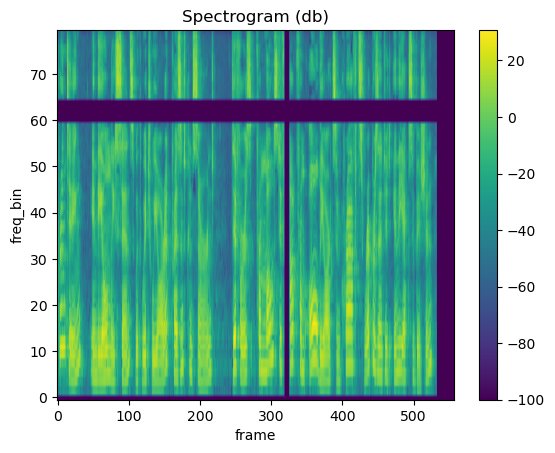

In [14]:
plot_spectrogram(train_transform(train_set[0][0].to(device)).cpu())

In [15]:
train_transform(train_set[0][0].to(device)).shape

torch.Size([80, 557])

In [16]:
def collate(batch):
    mel_waves = pad_sequence([b[0] for b in batch], batch_first=True).unsqueeze(1)
    labels = pad_sequence([b[1] for b in batch], batch_first=True, padding_value=vocab[''])
    rates = [b[2] for b in batch]
    return mel_waves, labels, rates

In [17]:
train_loader = DataLoader(train_set, bs, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_set, bs, shuffle=True, collate_fn=collate)

In [18]:
train_transform = nn.Sequential(T.Spectrogram(n_fft=n_ft, hop_length=h_len), T.FrequencyMasking(20), 
                                T.TimeMasking(20)).to(device)
valid_transform = T.Spectrogram(n_fft=n_ft, hop_length=h_len).to(device)

In [ ]:
class Block(nn.Module):
    
    def __init__(self, inp, out, kernel, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(inp, out, kernel_size=kernel, padding=kernel//2)
        self.conv2 = nn.Conv2d(out, out, kernel_size=kernel, padding=kernel//2)
        self.maxpool = nn.MaxPool2d(kernel, stride=stride, padding=kernel//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.batch_n = nn.BatchNorm2d(out)
    
    def forward(self, x):  
        
        x = self.relu(self.batch_n(self.conv1(x)))
        x = self.relu(self.batch_n(self.conv2(x)))
        x = self.maxpool(x)
        return x

class CNNFeatureExtractor(nn.Module):
    
    def __init__(self, output):
        
        super().__init__()
        self.block1 = Block(1, 8, 7, 4)
        self.block2 = Block(8, 12, 5, 2)
        self.block3 = Block(12, 16, 4, 2)
        self.block4 = Block(16, 20, 3, 1)
        self.output = nn.LazyLinear(output)
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        # reshaping to bs, c*frames* bin which has strided for 8 times
        # and using linear to increase bin features
        y = self.dropout((self.dropout(self.output((x).view(x.size(0), -1, x.size(2))))).relu())
        return y

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


In [21]:
class Transformer(nn.Module):
    
    def __init__(self, d_model):
        
        super().__init__()
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model, dropout=0.1)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=d_model*4, 
                                               batch_first=True)
        
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=6)
        dec_layer = nn.TransformerDecoderLayer(d_model, 4, d_model*4, batch_first=True)
        self.dec = nn.TransformerDecoder(dec_layer, 6)


    def forward(self, x, tgt):
        y = self.enc(x)
        z = self.positional_encoding(tgt * math.sqrt(self.d_model))
        y = self.dec(z, y)
        
        return y

In [22]:
class ASRNeural(nn.Module):
    
    def __init__(self, d_model):
        
        super().__init__()
        self.cnn_ = CNNFeatureExtractor(d_model)
        self.transformer = Transformer(d_model)
        self.embedding = nn.Embedding(len(vocab), d_model, padding_idx=0)
        self.head = nn.Linear(d_model, len(vocab))
        
    def forward(self, x, inp):
        y = self.cnn_(x)
        tgt = self.embedding(inp)
        y = self.transformer(y, tgt)
        y = self.head(y)
        return y

In [25]:
model = ASRNeural(d_model).to(device)

In [27]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

In [28]:
metric = Mean().to(device)

In [29]:
loss_train_hist = list()
loss_valid_hist = list()
pre_train_hist = list()
pre_valid_hist = list()
best_loss_valid = 1e+4
epoch_counter = 0

In [30]:
n = 100
for epoch in range(n):
    model, train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    valid_loss = evaluate(model, valid_loader, loss_fn)
    
    
    loss_train_hist.append(train_loss)
    loss_valid_hist.append(valid_loss)

    if valid_loss < best_loss_valid:
        torch.save(model,'modelx1.pt')
        best_loss_valid =  valid_loss
        print('Model SAVED') 

    epoch_counter +=1

epoch:0: 100%|██████████████████| 200/200 [01:17<00:00,  2.57batch/s, loss=2.85]


2.842803462346395
Model SAVED


epoch:1: 100%|██████████████████| 200/200 [01:17<00:00,  2.58batch/s, loss=2.84]


2.846130124727885


epoch:2: 100%|██████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.8448710282643637


epoch:3: 100%|██████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.8456206480662027


epoch:4: 100%|██████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.845895258585612


epoch:5: 100%|██████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.846165156364441


epoch:6: 100%|██████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.8456486304601034


epoch:7: 100%|██████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.845225715637207


epoch:8: 100%|██████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.845711088180542


epoch:9: 100%|██████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.845811915397644


epoch:10: 100%|█████████████████| 200/200 [01:16<00:00,  2.62batch/s, loss=2.85]


2.84664990901947


epoch:11: 100%|█████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.8453384399414063


epoch:12: 100%|█████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.8454305092493692


epoch:13: 100%|█████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.845331160227458


epoch:14: 100%|█████████████████| 200/200 [01:16<00:00,  2.61batch/s, loss=2.85]


2.845355733235677


epoch:15:   2%|▍                  | 4/200 [00:01<01:23,  2.34batch/s, loss=2.85]


KeyboardInterrupt: 

In [31]:
sum(p.numel() for p in model.parameters())

9763590

In [32]:
wave, label, sr = next(iter(train_loader))

In [33]:
model.eval()
generated = [vocab['B']]

for i in range(50):
    with torch.no_grad():
        preded = model(valid_transform(wave[0].to(device)).unsqueeze(0), 
                       torch.LongTensor(generated).to(device).unsqueeze(0))[:, -1]
    argm = preded.softmax(-1).argmax(-1)
    generated.append(argm)

In [34]:
generated

[1,
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 ten

In [40]:
preded.shape

torch.Size([1, 30])

In [39]:
vocab.get_itos()[3]

'U'

In [ ]:
torch.randn([10, 140, 300]) * math.sqrt(240)

In [ ]:
1.9311e+01